In [1]:
import json
import os

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

from collections import Counter

import rec_sys_lib as rs

# Recommendation system for scientific papers

### Goal

In the following study, we use (my) user history on the [SciRate website](https://scirate.com/) to create a recommendation system using content-based filtering. The idea is to use paper metadata such as the title, abstract, author list, and year of publication to create a similarity matrix between the papers the user scited on the website, and the paper uploaded in the relevant category of the arXiv in the last few years. In this way, the model should provide recommendations on new papers to read that we have not yet scited (and therefore, we probably have not yet read).

### Method

Since we only have access to the history of a single user (we cannot obtain the history of other people using the website), our model will only provide recommendations for this user and needs to be retrained to provide recommendations for other users.

We create a similarity matrix between the papers the user scited and the papers uploaded on the arXiv since 2016 in the relevant category (*quant-ph*, that is, quantum physics). The similarity score between a pair of papers is assigned by considering:

- the text (title and abstract) of the papers. We use standard NLP techniques to clean these fields, and we map the text into a vector space using the TF-IDF vectorization. The similarity is then computed using the cosine distance (inner product of normalized vectors).

- the author's list of the papers. The author list is embedded into a vector space using count vectorization, which essentially produces a vector of 0's and 1's, where 1 indicated that the authors wrote the paper, 0 that they did not. The exponential of cosine distance is used to gauge the similarity of papers using this field.

- the year of publication of the papers. We simply use a radial basis kernel to compute the similarity between the papers based on the year.

Once the similarity matrix is done, our content-based filtering recommender system used one of two methods:

- We either consider the average similarity of unscited papers, computed by first searching for the K most similar scited paper, and then averaging these similarities. We then select N unscited papers with the higher average similarity. We call this method *user-centered* in the following, to distinguish it from the next one.

- Otherwise, we use the average similarity to weigh the score the scited papers were given. The problem is that the user can only scite/non-scite a paper, and therefore we do not have a user score that we can use. Instead, we can use the number of scites a paper received as a score, although this score does not represent the opinion of the user alone, but rather that of the community of people using SciRate. This method might suggest papers that are less relevant for the user, but more popular among their community.

We test the above models using common measures used in the recommender system, in particular the *hit rate* and the *diversity* of the suggested papers. We find that the user-centric model works pretty well in suggesting new papers that are of interest to the user, and achieve a hit rate of ~ 4% while still maintaining a high diversity. The collective method, instead, suggests papers that are less relevant to the user, and are not even very popular on SciRate (but are likely quite similar to hyped papers the user scited).

A baseline model that randomly suggests paper is used and achieves a hit rate of ~ 0.2%, thus hinting that indeed the user-centric model here created might do a good job at suggesting papers. We end the study with a look at the top-N list generated by the two models created.

### Sections

- Download SciRate history
- Understanding user history
- Downloading unscited papers
- Data-preprocessing
    - Embedding titles and abstracts
    - Embedding authors
- Similarity Matrix
- Content-Based Filtering
    - Computing the hit rate
    - Computing the diversity
    - Producing the top-N list

### Make your recommender system

To train your model, you only need two things,

1) Your SciRate history. Get it by signing in on your SciRate account and accessing your profile. The history is available in JSON format.

2) A list of papers you have not scited. We use the papers published on the arXiv since 2016 on the *quant-ph* category. You can get the full metadata corpus of the arXiv at this [link](https://www.kaggle.com/Cornell-University/arxiv). We add a small script to the repository for you to extract from this corpus the papers relevant to you. Please open it, understand it, and change the year and category as it best fits you.

## Get SciRate user history

If you use SciRate, you can find your history on your profile page on the website, and download it as a JSON file.

In [2]:
rel_path_file = 'user_history/download_scites.json'
abs_path_file = os.path.abspath(rel_path_file)

with open(abs_path_file, encoding='utf-8') as fin:
    user_preferences = json.load(fin)

We store in a pandas database only the information we need to compute the similarity between papers.

In [3]:
columns = ['uid','author_str','abstract','title','pubdate','scites_count']
content = {}

for field in columns:
    content[field] = [item[field] for item in user_preferences]
    
df = pd.DataFrame.from_dict(content)
df.tail()

,uid,author_str,abstract,title,pubdate,scites_count
496,1607.05870,Tobias Fritz,We investigate the first-order theory of close...,Quantum logic is undecidable,2016-07-21T02:00:00.000Z,10
497,1607.05735,"Francesco Buscemi, Gilad Gour","The theory of majorization and its variants, i...",Quantum Relative Lorenz Curves,2016-07-21T02:00:00.000Z,15
498,1607.04591,"Mischa P. Woods, Ralph Silva, Jonathan Oppenheim","Processes such as quantum computation, or the ...",Autonomous quantum machines and the finite siz...,2016-07-18T02:00:00.000Z,19
499,1607.03104,Philippe Faist,We investigate fundamental connections between...,Quantum Coarse-Graining: An Information-Theore...,2016-07-13T02:00:00.000Z,30
500,1605.03564,"Joshua Lockhart, Simone Severini","We present new combinatorial objects, which we...",Combinatorial Entanglement,2016-05-12T02:00:00.000Z,26


We clean the text using standard NLP techniques, and we make a list of authors.

In [4]:
# Select the stemmer and the corpus of stopwords
wnl = WordNetLemmatizer()
stp_en = stopwords.words('english')

# Clean title and abstract
df['clean_abstract'] = df['abstract'].apply(rs.clean_text_lemmatize,args=(wnl,stp_en))
df['clean_title'] = df['title'].apply(rs.clean_text_lemmatize,args=(wnl,stp_en))

# Merge title and abstract together
df['clean_text'] = df['clean_title'] + df['clean_abstract']

# Get list of authors
df['author_list'] = df['author_str'].apply(rs.author_list)

# Get year of publication
df['year'] = df['pubdate'].apply(lambda item : int(item[:4]))

## Understanding the user history

In the following we play around with the user history, to gain a better understanding of the user.

### Check title and abstract

Let's see what are the most common words used in the papers scited by the user,

In [5]:
vocabulary = Counter(np.concatenate(df['clean_text']))
vocabulary.most_common(10)

[('quantum', 2102),
 ('state', 1061),
 ('theory', 496),
 ('system', 491),
 ('resource', 472),
 ('classical', 376),
 ('show', 359),
 ('channel', 358),
 ('entanglement', 341),
 ('information', 317)]

The length of the abstracts is

Range of abstract length = 11 - 194


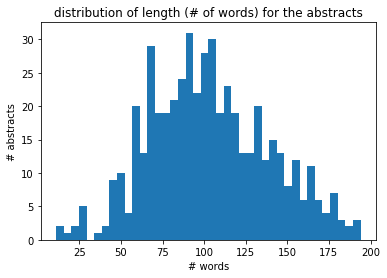

In [6]:
length_abstract = df['clean_abstract'].apply(len)

print('Range of abstract length = {} - {}'.format(min(length_abstract),max(length_abstract)))

plt.hist(length_abstract,bins=40)
plt.title('distribution of length (# of words) for the abstracts')
plt.xlabel('# words')
plt.ylabel('# abstracts')
plt.show()

while the length of the titles is

Range of title length = 1 - 15


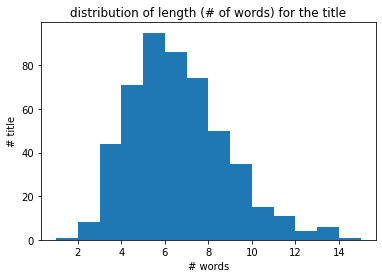

In [7]:
length_title = df['clean_title'].apply(len)

print('Range of title length = {} - {}'.format(min(length_title),max(length_title)))

plt.hist(length_title,bins=14)
plt.title('distribution of length (# of words) for the title')
plt.xlabel('# words')
plt.ylabel('# title')
plt.show()

### Check authors scited

Let's see which authors the user scited the most.

In [8]:
authors = Counter(np.concatenate(df['author_list']))
authors.most_common(10)

[('Andreas_Winter', 23),
 ('Mark_M_Wilde', 19),
 ('Gilad_Gour', 17),
 ('Álvaro_M_Alhambra', 12),
 ('Henrik_Wilming', 12),
 ('Xin_Wang', 11),
 ('John_Preskill', 11),
 ('Mario_Berta', 11),
 ('Bartosz_Regula', 10),
 ('Ryuji_Takagi', 10)]

And let's plot the distribution of frequencies an author was scited by the user,

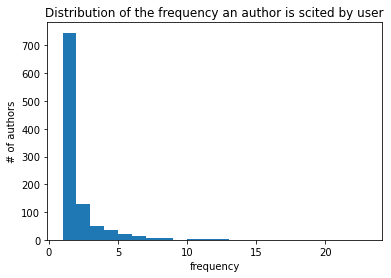

In [9]:
plt.hist(authors.values(),max(authors.values())-1)
plt.title('Distribution of the frequency an author is scited by user')
plt.xlabel('frequency')
plt.ylabel('# of authors')
plt.show()

We see that most of the authors were scited once or twice, and only a few are really liked by the user. One might want to use this information in the recommender system, as perhaps the user would like to see more stuff from an author they scited a lot. We do not do this here, but it should not be difficult to incorporate this knowledge into the model.

### Check year of scitation

Let's see how often the user scited during the years

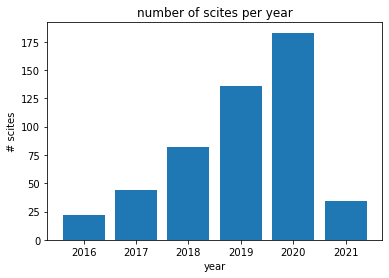

In [10]:
years = Counter(df['year'])

plt.bar(*zip(*sorted(years.most_common())))
plt.title('number of scites per year')
plt.xlabel('year')
plt.ylabel('# scites')
plt.show()

Clearly, the user grew more engaged with the website as time passed by.

## Get the unscited papers

We now need a list of unscited papers. We get this from the Kaggle website, where the arXiv metadata corpus is available (see the [link](https://www.kaggle.com/Cornell-University/arxiv)). In a separate script we added to this repository, we extracted the papers we need from the huge arXiv corpus, and we stored them as a pickled pandas file.

In [12]:
df_arxiv = pd.read_pickle('./dataset/dataset_quant_ph.pkl')
df_arxiv.tail()

,id,title,abstract,year,author_list
44330,quant-ph/9912051,Monte Carlo Hamiltonian from Stochastic Basis,In order to extend the recently proposed Mon...,2016,"[[Huang, C. Q., ], [Kröger, H., ], [Luo, X. Q...."
44331,quant-ph/9912061,Teleportation of entanglement for continuous v...,Teleportation of a pure two particle entangl...,2016,"[[Gorbachev, Author One V. N., ], [Trubilko, A..."
44332,quant-ph/9912098,Local environment can enhance fidelity of quan...,We show how an interaction with the environm...,2016,"[[Badziag, Piotr, ], [Horodecki, Michal, ], [H..."
44333,quant-ph/9912107,Quantum feedback control and classical control...,We introduce and discuss the problem of quan...,2016,"[[Doherty, Andrew C., ], [Habib, Salman, ], [J..."
44334,solv-int/9501009,Geometric phase effects for wavepacket revivals,The study of wavepacket revivals is extended...,2016,"[[Jarzynski, Christopher, ]]"


We remore the sicted papers form this list,

In [13]:
# Remove scited paper from the list
M,_ = df_arxiv.shape
bool_drop = np.zeros(M,dtype=bool)

for id_paper in df['uid']:
    bool_drop = np.logical_or(bool_drop, df_arxiv['id'] == id_paper)
    
df_arxiv = df_arxiv[~bool_drop]
df_arxiv.reset_index(drop=True,inplace=True)
    
print('We remove from the arXiv list {} entries (the one we scited)'.format(sum(bool_drop)))

We remove from the arXiv list 446 entries (the one we scited)


and we clean the text as we did before,

In [14]:
# Re-order author name to have name followed by surname
arrange_author_name = lambda item : [rs.chained_author(au[1]+' '+au[0]) for au in item]
df_arxiv['author_list'] = df_arxiv['author_list'].apply(arrange_author_name)

# Select the stemmer and the corpus of stopwords
wnl = WordNetLemmatizer()
stp_en = stopwords.words('english')

# Clean title and abstract
df_arxiv['clean_abstract'] = df_arxiv['abstract'].apply(rs.clean_text_lemmatize,args=(wnl,stp_en))
df_arxiv['clean_title'] = df_arxiv['title'].apply(rs.clean_text_lemmatize,args=(wnl,stp_en))

# Merge title and abstract together
df_arxiv['clean_text'] = df_arxiv['clean_title'] + df_arxiv['clean_abstract']

# Map year field into integer
df_arxiv['year'] = df_arxiv['year'].apply(int)

### Get an idea of the arXiv database

Again, we can get an idea of the arXiv database, for eaxample who are the authors that publish the most,

In [15]:
authors_arxiv = Counter(np.concatenate(df_arxiv['author_list']))
authors_arxiv.most_common(10)

[('GuangCan_Guo', 258),
 ('Franco_Nori', 176),
 ('JianWei_Pan', 154),
 ('ShaoMing_Fei', 140),
 ('ChuanFeng_Li', 134),
 ('Heng_Fan', 94),
 ('Martin_B_Plenio', 93),
 ('Pavel_Exner', 89),
 ('Matteo_G_A_Paris', 88),
 ('Liang_Jiang', 86)]

what length the abstracts are

Range of abstract length = 0 - 251


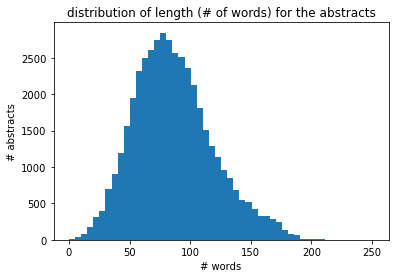

In [16]:
length_abstract = df_arxiv['clean_abstract'].apply(len)

print('Range of abstract length = {} - {}'.format(min(length_abstract),max(length_abstract)))

plt.hist(length_abstract,bins=50)
plt.title('distribution of length (# of words) for the abstracts')
plt.xlabel('# words')
plt.ylabel('# abstracts')
plt.show()

and what length the titles are,

Range of title length = 1 - 28


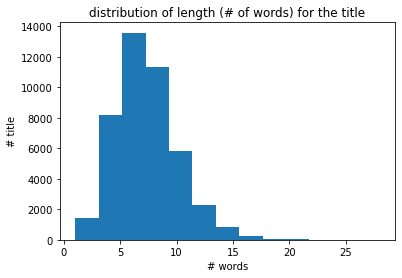

In [17]:
length_title = df_arxiv['clean_title'].apply(len)

print('Range of title length = {} - {}'.format(min(length_title),max(length_title)))

plt.hist(length_title,bins=13)
plt.title('distribution of length (# of words) for the title')
plt.xlabel('# words')
plt.ylabel('# title')
plt.show()

## Pre-processing the data

It is time to pre-process the data.

### Text pre-processing

We use TF-IDF for title+abstracts, as it seems like a natural one. An alternative could have been count vectorization, where the property of the whole corpus would have not been used.

In [18]:
token_scited = df['clean_text'].to_list()
token_unscited = df_arxiv['clean_text'].to_list()

text_scited, text_unscited = rs.vectorize_field(token_scited,token_unscited,TfidfVectorizer)

### Author pre-processing

We use Count vectorizer for the author field since we should really not penalize an author that appears quite often in our preferences (actually, we should do the opposite maybe).

In [19]:
token_scited = df['author_list'].to_list()
token_unscited = df_arxiv['author_list'].to_list()

author_scited, author_unscited = rs.vectorize_field(token_scited,token_unscited,CountVectorizer)

### Year preprocessing

There is not much we need to do here,

In [20]:
year_scited = df['year'].to_numpy()
N_scited = year_scited.size
year_scited = year_scited.reshape((N_scited,1))

year_unscited = df_arxiv['year'].to_numpy()
N_unscited = year_unscited.size
year_unscited = year_unscited.reshape((N_unscited,1))

Putting all together,

In [21]:
scited_papers = {}
scited_papers['text'] = text_scited
scited_papers['authors'] = author_scited
scited_papers['year'] = year_scited

unscited_papers = {}
unscited_papers['text'] = text_unscited
unscited_papers['authors'] = author_unscited
unscited_papers['year'] = year_unscited

## Similarity function

We are now ready to build the similarity matrix between papers the user scited and papers they did not scite. We use three different features of the papers to compute the similarity,

- The text similarity (this is the vector representation of title + abstract); we use cosine similarity between the TF-IDF vectors representing the text.

- Author similarity; again, we consider the cosine distance between the count vectors of the authors, and take the exponential of the distance, weighted with a coefficient gamma we should estimate using cross-validation

- Year similarity; (euclidean) distance between years of publication, where we take the exponential of the distance, weighted with another coefficient gamma we should estimate.

In the following, we use a specific choice for the gamma coefficient. One might prefer to tune these hyper-parameters using grid search, and selecting the model with a higher hit rate, for example.

In [22]:
gamma_authors = 0.2 # Smaller values of gamma make the author similarity less important
gamma_year = 0.005 # Smaller values of gamma make the year similarity less important

sim_matrix = rs.similarity_matrix(scited_papers,unscited_papers,gamma_authors,gamma_year)

Let's check how the similarity between pairs is distributed. This might give us an idea of whether the gammas of authors/years are too small or too big.

Similarity ranges between 0.0 and 0.91


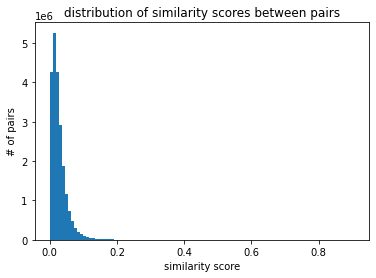

In [23]:
similarity_distribution = sim_matrix.flatten()

min_sim = np.min(similarity_distribution)
max_sim = np.max(similarity_distribution)

print('Similarity ranges between {:.2} and {:.2}'.format(min_sim,max_sim))

plt.hist(similarity_distribution,bins=100)
plt.title('distribution of similarity scores between pairs')
plt.xlabel('similarity score')
plt.ylabel('# of pairs')
plt.show()

## Content-base filtering

It is worth noticing, before we continue, that in SciRate we do not have a score scale (we cannot scite a paper with 5 stars, or 2 stars, but we can only scite it). However, one could use, as a rating system, the number of scitations a paper receives (this is interesting because it is not the user that gives this score, but the collection of users).


Thus, we have two immediate ways we can use to produce a top-N list,

- **user-centric method**: We compute the average similarity of a non-scited paper to the scited one, perhaps only focusing the average on the K closest scited papers. Then we order the unscited paper with respect to this average and return the first N. No collective information is used here.


- **"collective" method**: We compute the average score of unscited papers by considering the K scited papers that are the most similar to it, and compute a weighted sum of the number of scitation these papers received. This is a way of incorporating into the process the perspective of the collection of users that use Scirate.

It is unclear to me which one would be best to use, and what kind of results we would get. Thus, we are going to build both methods here, and see what happens.

### Compute hit rate

Here we use Leave-One-Out Cross-Validation to compute the hit rate of the model. To compare our model to something else, we create a simple baseline that suggests N=100 random papers.

In [22]:
# One might be interested in performing grid search over the following parameters
gamma_authors = 0.2
gamma_year = 0.005
K=40

# The number of papers in the top-N list we generate
N_sample = 100

The similarity matrices can be generated beforehand,

In [25]:
matrix_unscited = rs.similarity_matrix(scited_papers,unscited_papers,gamma_authors,gamma_year)
matrix_scited = rs.similarity_matrix(scited_papers,scited_papers,gamma_authors,gamma_year)

The hit rate for the user-centric method,

In [26]:
model_hit_rate = rs.compute_hit_rate(matrix_unscited,
                                     matrix_scited,
                                     N_scited,
                                     K,
                                     N_sample
                                    )

print('The user-centric model hit rate is {:.2}'.format(model_hit_rate))

The user-centric model hit rate is 0.042


The hit rate for the collective method is,

In [28]:
scores = df['scites_count'].to_numpy()

model_hit_rate = rs.compute_hit_rate(matrix_unscited,
                                     matrix_scited,
                                     N_scited,
                                     K,
                                     N_sample,
                                     scores,
                                     user_centric=False
                                    )

print('The collective model hit rate is {:.2}'.format(model_hit_rate))

The collective model hit rate is 0.004


The baseline is obtained via sampling without replacements, and the probability that the left out sample is selected if we sample N papers from M+1 unscited papers (M are the unscited ones, 1 is the left out paper) is p = N/(M+1)

In [29]:
_,M = matrix_unscited.shape

print('The baseline hit rate is {:.2}'.format(N_sample/(M+1)))

The baseline hit rate is 0.0023


From the above, it is clear that our user-centric model is providing meaningful suggestions since the hit rate is around 4% (it is expected to be low, especially since the model can choose from ~45k unscited papers having only knowledge of ~500 scited papers).

The collective model is not performing very well, with a hit rate of around 0.4%, but this is to be expected since it is using the score given by other users to decide which paper is worth reading, and the user might be interested in niche topics within the broad community.

Finally, the hit rate of the baseline model is 0.2%, much lower than that of our user-centric model.


### Compute diversity

We can now compute the diversity of the papers our algorithm is suggesting. The diversity is obtained by computing the average similarity of each pair of suggested papers.

For the user-centric model, we have

In [29]:
N_sample = 20

model = rs.ContentBasedFiltering(sim_matrix, K=40, N=N_sample)
model.fit()

# Get the similarity for the top-N papers suggested
# (to do it for all unscited papers would be too much!)
top_N_papers = {}
top_N_papers['text'] = unscited_papers['text'][model.top_N_list]
top_N_papers['authors'] = unscited_papers['authors'][model.top_N_list]
top_N_papers['year'] = unscited_papers['year'][model.top_N_list]

top_N_sim_matrix = rs.similarity_matrix(top_N_papers,top_N_papers,gamma_authors,gamma_year)
        
rs.diversity(top_N_sim_matrix, range(N_sample))    

0.8375783384473559

While for the collective model,

In [32]:
model = rs.ContentBasedFiltering(sim_matrix, K=40, N=20)
model.set_score_scited(scores)
model.fit(user_centric=False)

# Get the similarity for the top-N papers suggested
# (to do it for all unscited papers would be too much!)
top_N_papers = {}
top_N_papers['text'] = unscited_papers['text'][model.top_N_list]
top_N_papers['authors'] = unscited_papers['authors'][model.top_N_list]
top_N_papers['year'] = unscited_papers['year'][model.top_N_list]

top_N_sim_matrix = rs.similarity_matrix(top_N_papers,top_N_papers,gamma_authors,gamma_year)
        
rs.diversity(top_N_sim_matrix, range(N_sample))    

0.8460246504807224

The two methods seems to both provide quite diverse papers. Let's check this by actually looking at the suggestions the two models produce.

### Model top-N lists

We can now have a look at the top-N suggested paper we get from the two methods, starting with the user-centric method,

In [33]:
model = rs.ContentBasedFiltering(sim_matrix, K=40, N=5)
model.fit()

model.show_top_n_list(df_arxiv)

1) Operational Resource Theory of Quantum Channels

Yunchao_Liu, Xiao_Yuan

  Quantum resource theories have been widely studied to systematically
characterize the non-classicality of quantum systems. Most resource theories
focus on quantum states and study their interconversions. Although quantum
channels are generally used as the tool for state manipulation, such a
manipulation capability can be naturally regarded as a generalized quantum
resource, leading to an open research direction in the resource theories of
quantum channels. Various resource-theoretic properties of channels have been
investigated, however, without treating channels themselves as operational
resources that can also be manipulated and converted. In this Letter, we
address this problem by first proposing a general resource framework for
quantum channels and introducing resource monotones based on general distance
quantifiers of channels. We study the interplay between channel and state
resource theories by relatin

The suggestions of the collective method are, instead,

In [31]:
# The score we use for scited paper is the number of scites the paper got (depends on other users)
scores = df['scites_count'].to_numpy()

model = rs.ContentBasedFiltering(sim_matrix, K=40, N=3)
model.set_score_scited(scores)
model.fit(user_centric=False)

model.show_top_n_list(df_arxiv)

1) Improved success probability with greater circuit depth for the quantum
  approximate optimization algorithm

Andreas_Bengtsson, Pontus_Vikstål, Christopher_Warren, Marika_Svensson, Xiu_Gu, Anton_Frisk_Kockum, Philip_Krantz, Christian_Križan, Daryoush_Shiri, IdaMaria_Svensson, Giovanna_Tancredi, Göran_Johansson, Per_Delsing, Giulia_Ferrini, Jonas_Bylander

  Present-day, noisy, small or intermediate-scale quantum processors---although
far from fault-tolerant---support the execution of heuristic quantum
algorithms, which might enable a quantum advantage, for example, when applied
to combinatorial optimization problems. On small-scale quantum processors,
validations of such algorithms serve as important technology demonstrators. We
implement the quantum approximate optimization algorithm (QAOA) on our hardware
platform, consisting of two superconducting transmon qubits and one
parametrically modulated coupler. We solve small instances of the NP-complete
exact-cover problem, with 96.6%